## Bayesian parameter estimation using MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots
from statsmodels.nonparametric.kde import KDEUnivariate

## Probability model

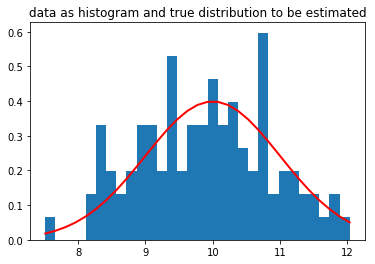

In [2]:
# Generate data from a probability model, here a Gaussian pdf, then learn its parameters, 
# mean and covariance, from this data

np.random.seed(100)
mu, sigma = 10, 1 # true mean and standard deviation
data = np.random.normal(mu, sigma, 100)
np.random.seed()

# plot the data and true distribution
count, bins, ignored = plt.hist(data, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('data as histogram and true distribution to be estimated')
plt.show()

In [3]:
# create an instance of class Model
candidate_model = Model(model_type = 'pdf', model_name='normal', 
                        prior_name = ['uniform','lognormal'], prior_params = [[0, 15], [1, 0, 1]])

AttributeError: 'Distribution' object has no attribute 'n_params'

In [ ]:
# Learn the unknown parameters using MCMC
bayes_estimator = BayesParameterEstimation(data=data, sampling_method = 'MCMC', nsamples=500, 
                                           pdf_proposal = 'Normal', pdf_proposal_scale=[1, 1], model=candidate_model, 
                                           algorithm = 'MH', jump=10, nburn=10, 
                                           seed=np.array([1.0, 0.2]))

In [ ]:
# print results
s = bayes_estimator.samples
plt.scatter(s[:,0],s[:,1])
plt.scatter(10, 1, marker = '+', label='true parameter')
plt.title('MCMC samples')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,2)

domain = np.linspace(0, 15, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,0].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax[0].plot(domain, np.exp(log_dens))
ax[0].set_title('posterior pdf of \theta=\mu')

domain = np.linspace(0, 2, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,1].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax[1].plot(domain, np.exp(log_dens))
ax[1].set_title('posterior pdf of \theta=\sigma')

plt.show()

## Regression model

In [4]:
# Generate data from a quadratic function
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
z = RunModel(samples=param_true, model_script='pfn_models.py', model_object_name = 'model_quadratic', 
             var_names = ['theta_1', 'theta_2'])
data = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)
[ -2.20501341   0.34173956   0.27870117   0.74676964   2.4925227
   2.57137294   3.76359656   6.43268541   8.85390616   8.03105948
   9.53639311  12.04884941  14.60413421  16.16485449  19.58274136
  20.87533422  23.25361351  30.09360291  30.25159786  34.44589979
  36.8800238   39.88236919  46.26741868  48.43037055  53.37759434
  57.31738313  62.40792722  67.56293256  71.645436    76.10385802
  79.65128193  85.80178227  92.08374715  99.25981211 103.77374736
 109.4488853  113.50174493 123.73406638 128.60802127 134.16890913
 139.7569583  149.64335152 156.57659321 162.82208901 169.74272883
 176.7008832  185.02177658 192.51919094 202.37143152 210.85828345]


In [5]:
candidate_model = Model(n_params=2, model_type='python', 
                        model_script='pfn_models.py', model_object_name = 'model_quadratic',
                        error_covariance=error_covariance)

In [6]:
bayes_estimator = BayesParameterEstimation(data=data, model=candidate_model, sampling_method = 'MCMC', nsamples=500,
                                           algorithm = 'MH', jump=10, nburn=0, pdf_proposal = 'Normal',
                                           pdf_proposal_scale = [0.1, 0.05], seed = [0.5, 2.5])

Successful execution of the MCMC design


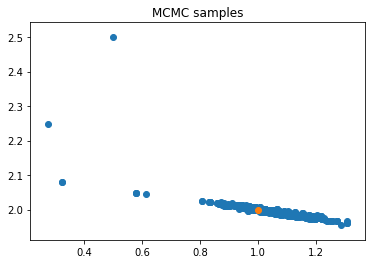

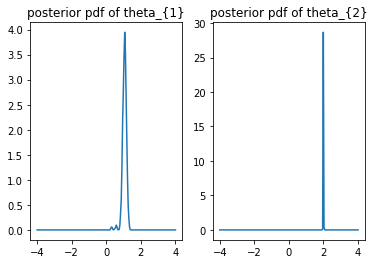

In [7]:
s = bayes_estimator.samples
plt.scatter(s[:,0],s[:,1])
plt.scatter(1.0, 2.0, label='true value')
plt.title('MCMC samples')
plt.show()

fig, ax = plt.subplots(1,2)

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[0].plot(domain, pdf_, label='prior')
ax[0].set_title('posterior pdf of theta_{1}')

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,1])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[1].plot(domain, pdf_, label='prior')
ax[1].set_title('posterior pdf of theta_{2}')

plt.show()

In [8]:
Diagnostics(sampling_method='MCMC', sampling_outputs = bayes_estimator)

NameError: name 'Diagnostics' is not defined